# 介绍

数据科学与机器学习在贷款审批决策中扮演着至关重要的角色。这一领域尤其受到初创企业的关注，因为许多公司认为传统银行的贷款审批模型存在优化空间。因此，开发出能够同时惠及贷款机构和借款人的更优贷款策略成为一个有前景的方向。

本研究中，我们使用了一家银行的贷款数据集。该数据集包含了所有贷款申请信息，包括银行是否批准了贷款，以及借款人最终是否成功偿还贷款。此外，我们还拥有借款人在申请贷款时的相关个人信息。

我们的目标是设计一个比现有银行模型更优的贷款审批模型。具体而言，假设银行的贷款决策遵循以下简单规则：
- 如果贷款被批准，但借款人未能偿还，则银行损失1个单位。
- 如果贷款被批准且借款人成功偿还，则银行获得1个单位收益。
- 如果贷款未被批准，银行的收益为0。

基于这些规则，我们将比较现有银行模型的盈利能力与我们改进模型的盈利能力。

此外，我们将重点分析影响预测结果的最重要变量，特别关注借款人在申请贷款时是否就业（变量 "is_employed"），并解释其对模型的影响及背后的原因。最后，我们将讨论在现有数据之外，是否有其他变量可以进一步提升模型的表现。

# 数据导入

导入常用的库：

In [120]:
import warnings
warnings.simplefilter('ignore')

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

接着导入数据集：

In [122]:
loan = pd.read_csv("./../dataset/12. loan/loan_table.csv", parse_dates=['date'])
loan.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [123]:
borrower = pd.read_csv("./../dataset/12. loan/borrower_table.csv")
borrower.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


# 数据处理

合并两个数据集：

In [124]:
data = pd.merge(left=loan, right=borrower, on='loan_id')

In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 16 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   loan_id                                          101100 non-null  int64         
 1   loan_purpose                                     101100 non-null  object        
 2   date                                             101100 non-null  datetime64[ns]
 3   loan_granted                                     101100 non-null  int64         
 4   loan_repaid                                      47654 non-null   float64       
 5   is_first_loan                                    101100 non-null  int64         
 6   fully_repaid_previous_loans                      46153 non-null   float64       
 7   currently_repaying_other_loans                   46153 non-null   float64       
 8   total_credit_card_limit 

In [126]:
data.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


从整个数据集中筛选出银行批准了贷款的样本（loan_granted == 1 表示贷款已批准），并将其赋值给 data 变量。这相当于保留所有已经批准的贷款，并忽略未批准的贷款记录。

In [127]:
# choose data with loan granted 
# the data with loan not granted is not useful for profit calculation
data = data[data['loan_granted'] == 1]
data.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4
6,780070,business,2012-03-14,1,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2
7,303138,emergency_funds,2012-08-31,1,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2
8,91475,investment,2012-05-25,1,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1


根据问题描述，模型的收益计算规则是基于批准贷款之后的结果：如果贷款被批准且借款人未能偿还，损失1；如果贷款被批准且借款人成功偿还，收益1；如果贷款未被批准，收益为0。

因此，未批准贷款的记录对于收益计算没有贡献，因为这些情况下银行的收益始终是0。因此，这段代码通过过滤掉未批准贷款的记录，将注意力集中在批准贷款的样本上，以便后续计算模型在贷款批准后的盈亏情况。

In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47654 entries, 3 to 101098
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   loan_id                                          47654 non-null  int64         
 1   loan_purpose                                     47654 non-null  object        
 2   date                                             47654 non-null  datetime64[ns]
 3   loan_granted                                     47654 non-null  int64         
 4   loan_repaid                                      47654 non-null  float64       
 5   is_first_loan                                    47654 non-null  int64         
 6   fully_repaid_previous_loans                      21865 non-null  float64       
 7   currently_repaying_other_loans                   21865 non-null  float64       
 8   total_credit_card_limit                 

检查数据集中的缺失值的情况：

In [129]:
data.isnull().sum()

loan_id                                                0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
loan_repaid                                            0
is_first_loan                                          0
fully_repaid_previous_loans                        25789
currently_repaying_other_loans                     25789
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year      903
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
dtype: int64

接着使用date特征来生成新的时间特征：

In [130]:
data['month'] = data['date'].apply(lambda x: x.month)
data['week'] = data['date'].apply(lambda x: x.week)
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

In [131]:
# drop useless features
data = data.drop(labels=['loan_id', 'date', 'loan_granted'], axis=1, inplace=False)

# 可视化

进行可视化，查看贷款偿还与其他因素的情况：

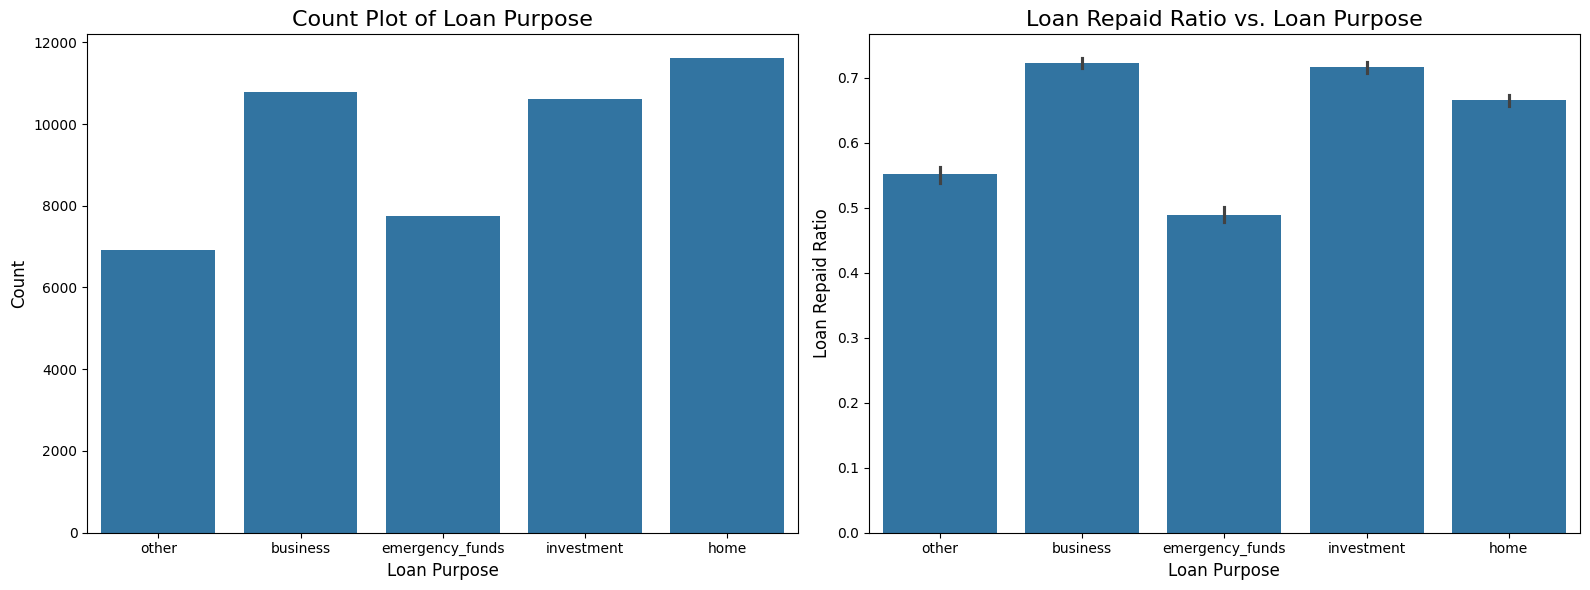

In [132]:
# visualization of 'loan_purpose'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='loan_purpose', data=data, ax=ax[0])
ax[0].set_xlabel('Loan Purpose', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Loan Purpose', fontsize=16)

sns.barplot(x='loan_purpose', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('Loan Purpose', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. Loan Purpose', fontsize=16)
plt.tight_layout()
plt.show()

这幅可视化包含两个柱状图，分别展示了贷款用途与贷款申请数量及其偿还比例的关系。

左图显示了不同贷款用途的申请数量分布。X轴代表不同的贷款目的，包括“other”、“business”、“emergency funds”、“investment”和“home”，Y轴则表示每个贷款用途的申请数量。从图中可以看出，贷款用于“business”和“home”的申请数量最多，接近12000笔，说明这些用途的贷款需求量较大。而用于“other”的贷款申请数量相对较少，大约为8000笔左右，“emergency funds”的申请数量则处于中间位置。

右图展示了不同贷款用途的贷款偿还率情况。X轴同样表示贷款用途，Y轴则是贷款的偿还比例。从图中可以看出，"business"和"home"用途的贷款偿还率最高，约为70%，意味着这些用途的贷款违约率较低。而"emergency funds"的偿还率最低，低于50%，表明此类贷款的违约风险较高。"investment"的偿还率介于两者之间，大约为60%。此外，"other"用途的贷款偿还率也相对较低，接近50%。

综合来看，商业和住房用途的贷款不仅申请数量较多，而且偿还率较高，反映出相对较低的违约风险。相反，用于应急资金的贷款申请数量较少且偿还率最低，显示出较高的违约风险。

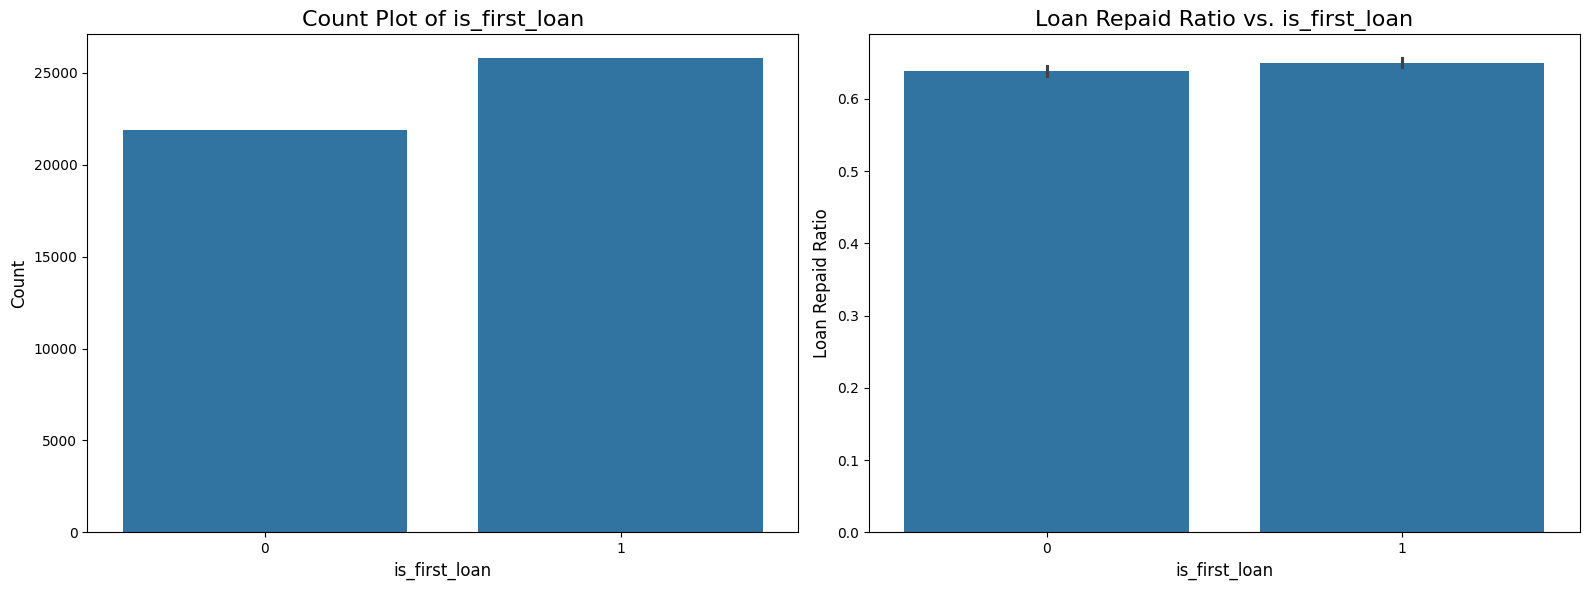

In [133]:
# visualization of 'is_first_loan'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='is_first_loan', data=data, ax=ax[0])
ax[0].set_xlabel('is_first_loan', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of is_first_loan', fontsize=16)

sns.barplot(x='is_first_loan', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('is_first_loan', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. is_first_loan', fontsize=16)
plt.tight_layout()
plt.show()

该可视化由两个柱状图构成，分别展示了首次贷款（is_first_loan）与贷款申请数量及其偿还率之间的关系。

左侧的图表展示了首次贷款的申请数量分布。X轴代表是否为首次贷款（0表示非首次贷款，1表示首次贷款），Y轴则代表不同类别的贷款申请数量。图中显示，首次贷款的申请数量略高于非首次贷款，首次贷款大约有25000笔，而非首次贷款约有23000笔。总体来看，两者的申请数量差异并不大，表明首次贷款者和非首次贷款者的需求量都相对接近。

右侧的图表显示了贷款偿还率与是否为首次贷款的关系。X轴同样表示是否为首次贷款，Y轴表示贷款偿还比例。数据显示，首次贷款和非首次贷款的偿还率几乎相同，均接近0.65。这表明，借款人是否为首次申请贷款对其偿还能力没有显著影响，两类借款人的违约风险相似。

综上所述，该可视化结果表明，首次贷款与非首次贷款的申请数量相差不大，且两者的贷款偿还率也非常接近，均在65%左右。也就是说，借款人是否为首次贷款并不是影响贷款偿还能力的关键因素，银行可能需要结合其他变量来进行风险评估。

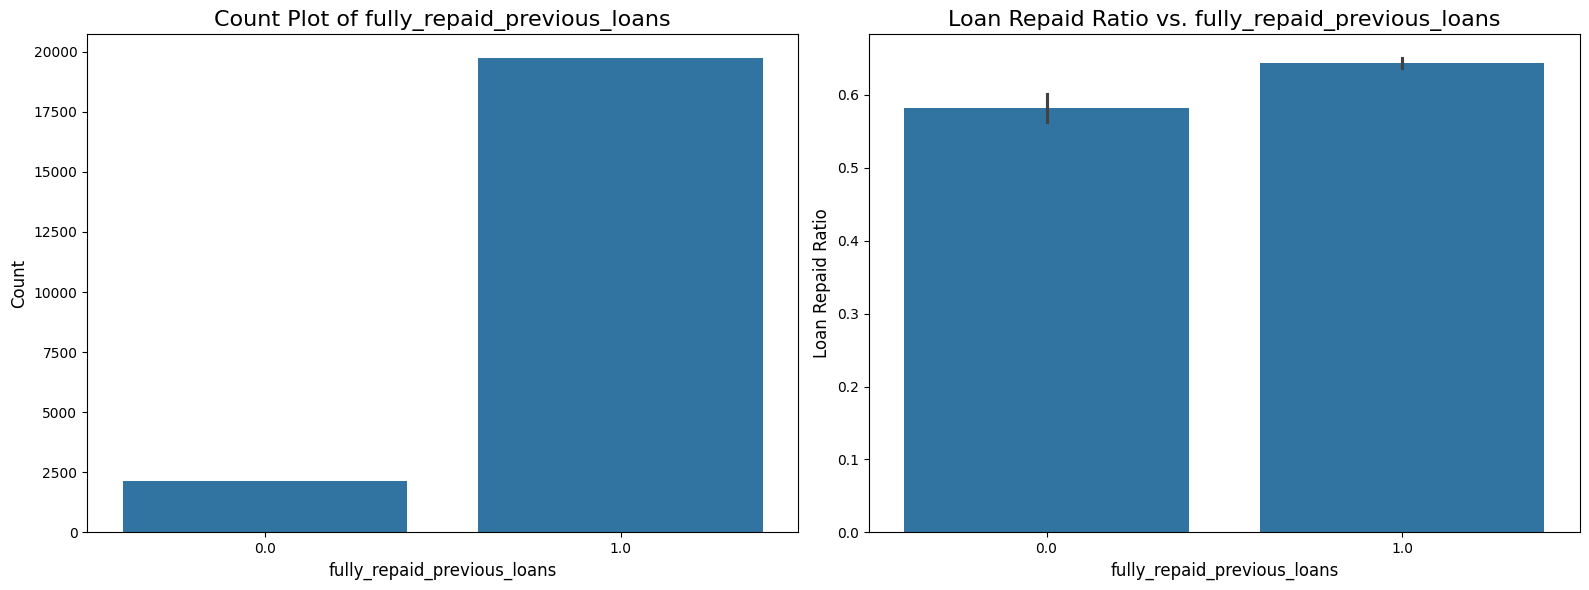

In [134]:
# visualization of 'fully_repaid_previous_loans'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='fully_repaid_previous_loans', data=data, ax=ax[0])
ax[0].set_xlabel('fully_repaid_previous_loans', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of fully_repaid_previous_loans', fontsize=16)

sns.barplot(x='fully_repaid_previous_loans', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('fully_repaid_previous_loans', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. fully_repaid_previous_loans', fontsize=16)
plt.tight_layout()
plt.show()

这幅可视化同样由两个柱状图组成，分别展示了完全偿还之前贷款（fully_repaid_previous_loans）与贷款申请数量及其偿还率之间的关系。

左侧图表显示了借款人之前是否已完全偿还贷款的分布情况。X轴表示借款人是否完全偿还之前的贷款（0表示未完全偿还，1表示已完全偿还），Y轴表示不同类别的贷款申请数量。从图中可以看出，绝大多数借款人之前已经完全偿还了贷款，申请数量接近20000笔。而未完全偿还之前贷款的借款人数量则显著较少，只有大约2500笔左右。

右侧图表展示了贷款偿还率与之前是否完全偿还贷款的关系。X轴表示借款人是否完全偿还之前的贷款，Y轴则是贷款的偿还比例。从图中可以看出，之前已完全偿还贷款的借款人偿还新贷款的比例略高，接近0.65。而未完全偿还之前贷款的借款人，偿还率较低，约为0.55。这表明，之前完全偿还贷款的借款人在偿还新贷款时违约风险更低。

综上所述，之前有过完全偿还贷款经历的借款人数量显著更多，且他们的贷款偿还率也更高。这说明借款人的历史贷款偿还记录对当前贷款的偿还能力有一定的预测作用，完全偿还之前贷款的借款人违约风险更低，银行可以将其作为一个重要的参考因素。

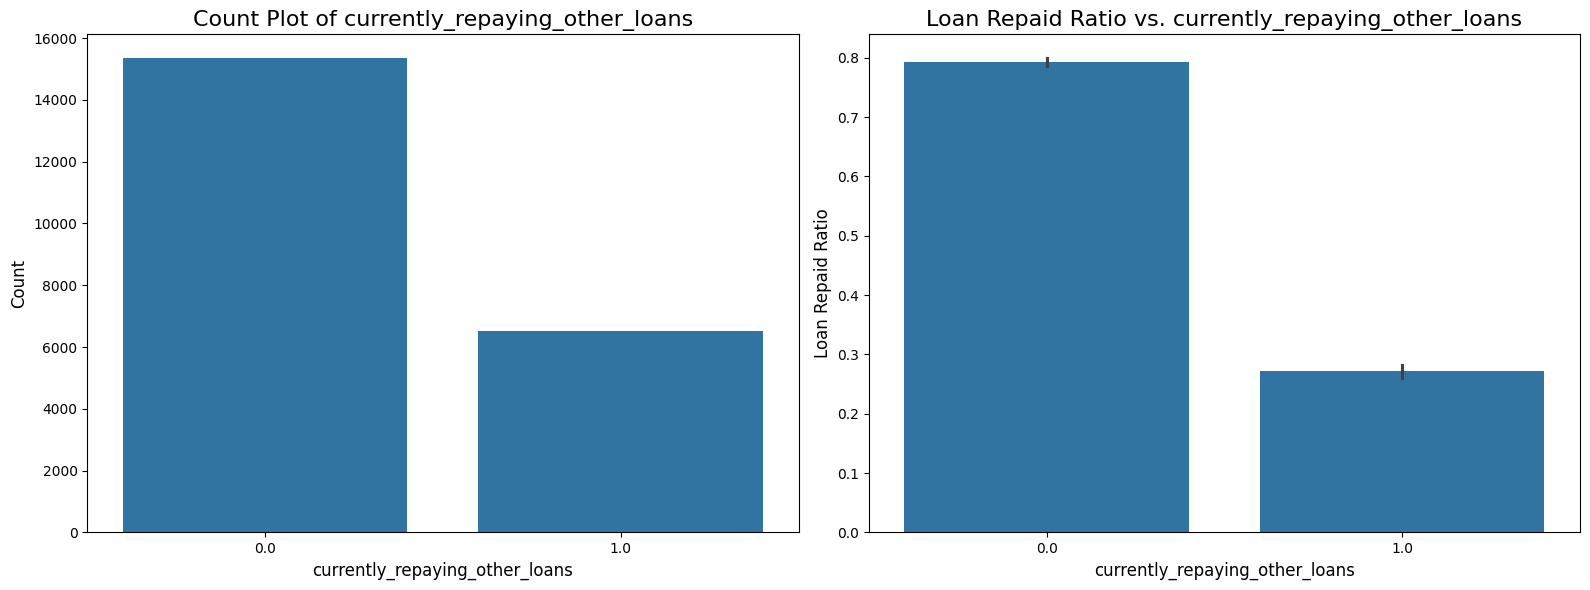

In [135]:
# visualization of 'currently_repaying_other_loans'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='currently_repaying_other_loans', data=data, ax=ax[0])
ax[0].set_xlabel('currently_repaying_other_loans', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of currently_repaying_other_loans', fontsize=16)

sns.barplot(x='currently_repaying_other_loans', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('currently_repaying_other_loans', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. currently_repaying_other_loans', fontsize=16)
plt.tight_layout()
plt.show()

这幅可视化展示了借款人是否正在偿还其他贷款（currently_repaying_other_loans）与贷款申请数量及其偿还率之间的关系。

左侧图表显示了借款人当前是否在偿还其他贷款的分布情况。X轴表示是否正在偿还其他贷款（0表示没有，1表示正在偿还），Y轴则表示贷款申请的数量。从图中可以看出，绝大多数借款人没有正在偿还其他贷款，申请数量接近16000笔；而正在偿还其他贷款的借款人相对较少，申请数量约为6000笔。这表明大部分借款人在申请新的贷款时，并没有同时偿还其他贷款。

右侧图表展示了贷款偿还率与借款人是否正在偿还其他贷款的关系。X轴表示借款人是否正在偿还其他贷款，Y轴则是贷款的偿还比例。从图中可以看出，未偿还其他贷款的借款人偿还新贷款的比例较高，接近0.8。而正在偿还其他贷款的借款人，偿还率显著较低，约为0.4。这表明，借款人当前是否有其他贷款未偿还与其偿还新贷款的能力有较强的相关性，正在偿还其他贷款的借款人违约风险较高。

综上所述，当前未偿还其他贷款的借款人不仅在申请贷款时占据多数，而且他们的贷款偿还率也显著高于正在偿还其他贷款的借款人。这意味着，银行在评估贷款申请时，应该重点考虑借款人是否有其他未偿还贷款，因为这可能是影响其偿还新贷款能力的重要因素。

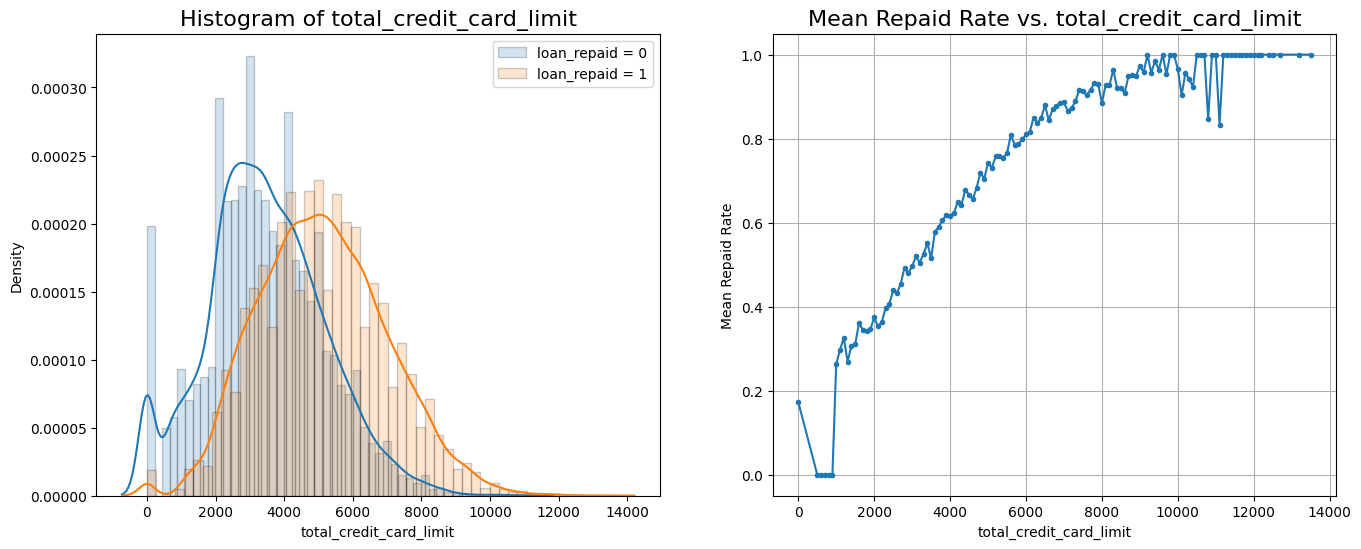

In [136]:
# Visualization of 'total_credit_card_limit'
grouped = data[['total_credit_card_limit', 'loan_repaid']].groupby('total_credit_card_limit')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['total_credit_card_limit'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['total_credit_card_limit'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of total_credit_card_limit', fontsize=16)
ax[0].legend()
ax[1].plot(mean['total_credit_card_limit'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. total_credit_card_limit', fontsize=16)
ax[1].set_xlabel('total_credit_card_limit')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

这幅可视化由两个图表组成，分别展示了信用卡总额度（total_credit_card_limit）与贷款偿还情况的关系。

左侧的图表是信用卡总额度的直方图，显示了不同额度下，贷款被偿还（loan_repaid = 1）和未偿还（loan_repaid = 0）的分布情况。X轴表示信用卡总额度，Y轴表示密度（Density）。图中显示，信用卡总额度较低（在2000左右）的借款人，未偿还贷款的比例更高（蓝色线），而信用卡额度较高的借款人（4000以上），偿还贷款的比例更高（橙色线）。这表明，信用卡总额度可能与借款人的还款能力相关，额度较高的借款人更有可能按时偿还贷款。

右侧的图表展示了平均贷款偿还率（Mean Repaid Rate）与信用卡总额度之间的关系。X轴表示信用卡总额度，Y轴表示平均偿还率。可以看出，随着信用卡总额度的增加，贷款的平均偿还率也在显著上升，尤其是在额度达到4000左右时，偿还率开始快速上升，最终趋于稳定，接近1。这进一步说明，信用卡总额度较高的借款人更有可能偿还贷款。

总结来看，信用卡总额度与借款人是否能够按时偿还贷款具有明显的相关性。额度较高的借款人偿还贷款的概率更大，反之，信用卡额度较低的借款人违约风险更高。这一发现可以帮助银行在贷款审批过程中更好地评估借款人的还款能力，合理调整信用额度。

In [137]:
print(data.dtypes)

loan_purpose                                        object
loan_repaid                                        float64
is_first_loan                                        int64
fully_repaid_previous_loans                        float64
currently_repaying_other_loans                     float64
total_credit_card_limit                              int64
avg_percentage_credit_card_limit_used_last_year    float64
saving_amount                                        int64
checking_amount                                      int64
is_employed                                          int64
yearly_salary                                        int64
age                                                  int64
dependent_number                                     int64
month                                                int64
week                                                 int64
dayofweek                                            int64
dtype: object


In [138]:
not_null = data.dropna(subset=['avg_percentage_credit_card_limit_used_last_year', 'loan_repaid'])

In [139]:
grouped = not_null.groupby('avg_percentage_credit_card_limit_used_last_year')
mean = grouped['loan_repaid'].mean().reset_index()  # 只对 'loan_repaid' 列计算均值

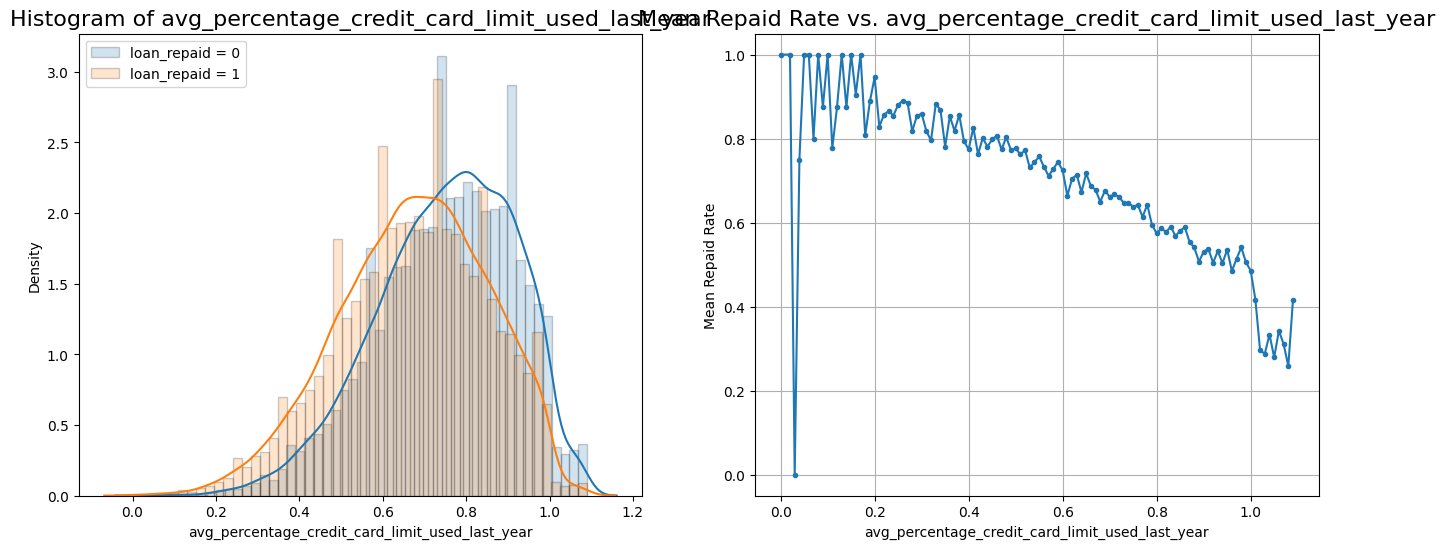

In [140]:
# 移除 'avg_percentage_credit_card_limit_used_last_year' 和 'loan_repaid' 列中的空值
not_null = data.dropna(subset=['avg_percentage_credit_card_limit_used_last_year', 'loan_repaid'])

# 按 'avg_percentage_credit_card_limit_used_last_year' 分组并计算 'loan_repaid' 的均值
grouped = not_null.groupby('avg_percentage_credit_card_limit_used_last_year')
mean = grouped['loan_repaid'].mean().reset_index()

# 定义直方图参数
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

# 创建两个子图，分别展示直方图和均值线
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# 绘制不同贷款偿还情况的信用卡使用百分比分布
sns.distplot(not_null[not_null['loan_repaid'] == 0]['avg_percentage_credit_card_limit_used_last_year'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(not_null[not_null['loan_repaid'] == 1]['avg_percentage_credit_card_limit_used_last_year'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)

ax[0].set_title('Histogram of avg_percentage_credit_card_limit_used_last_year', fontsize=16)
ax[0].legend()

# 绘制平均偿还率与信用卡使用百分比之间的关系
ax[1].plot(mean['avg_percentage_credit_card_limit_used_last_year'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. avg_percentage_credit_card_limit_used_last_year', fontsize=16)
ax[1].set_xlabel('avg_percentage_credit_card_limit_used_last_year')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)

plt.show()

该可视化由两个图表组成，展示了借款人在上一年使用信用卡额度的百分比（`avg_percentage_credit_card_limit_used_last_year`）与贷款偿还情况之间的关系。

**左侧图表：信用卡额度使用百分比的直方图**

左侧的图表是一个直方图，显示了不同信用卡额度使用百分比下，贷款是否偿还的分布。X轴表示借款人上一年使用信用卡额度的百分比，Y轴表示密度（Density），图中的蓝色线条代表未偿还贷款的分布，橙色线条代表成功偿还贷款的分布。

从图中可以看到，使用信用卡额度的百分比在0.4到0.7之间时，贷款偿还率较高（橙色区域密度较大），而使用额度较低（小于0.3）或较高（大于0.8）时，未偿还贷款的比例增多（蓝色区域密度较大）。这表明借款人在信用卡额度的使用百分比对贷款的偿还情况有一定影响，过高或过低的信用卡使用率可能增加贷款违约的风险。

**右侧图表：平均偿还率与信用卡额度使用百分比的关系**

右侧的图表展示了平均贷款偿还率与信用卡使用百分比的关系。X轴表示信用卡使用百分比，Y轴表示平均偿还率。从图中可以看到，随着信用卡使用百分比的增加，贷款的平均偿还率呈现出先上升后下降的趋势。

具体来说，当信用卡使用百分比较低时（0到0.3之间），平均偿还率相对较低，但随着信用卡使用百分比的上升，偿还率逐渐增高，并在0.6至0.7左右达到顶峰，接近1。然而，当使用百分比超过0.7之后，平均偿还率开始下降，表明借款人如果使用了过多的信用卡额度，其偿还贷款的能力可能会降低。

**总结**

该可视化表明，信用卡额度的使用百分比与贷款的偿还情况有显著相关性。使用信用卡额度的百分比适中（0.4至0.7）时，贷款偿还率最高；而过度或过少使用信用卡额度的借款人，违约风险较高。这一信息可以帮助贷款机构在评估借款人的信用风险时，更好地利用信用卡使用情况作为一个重要指标。

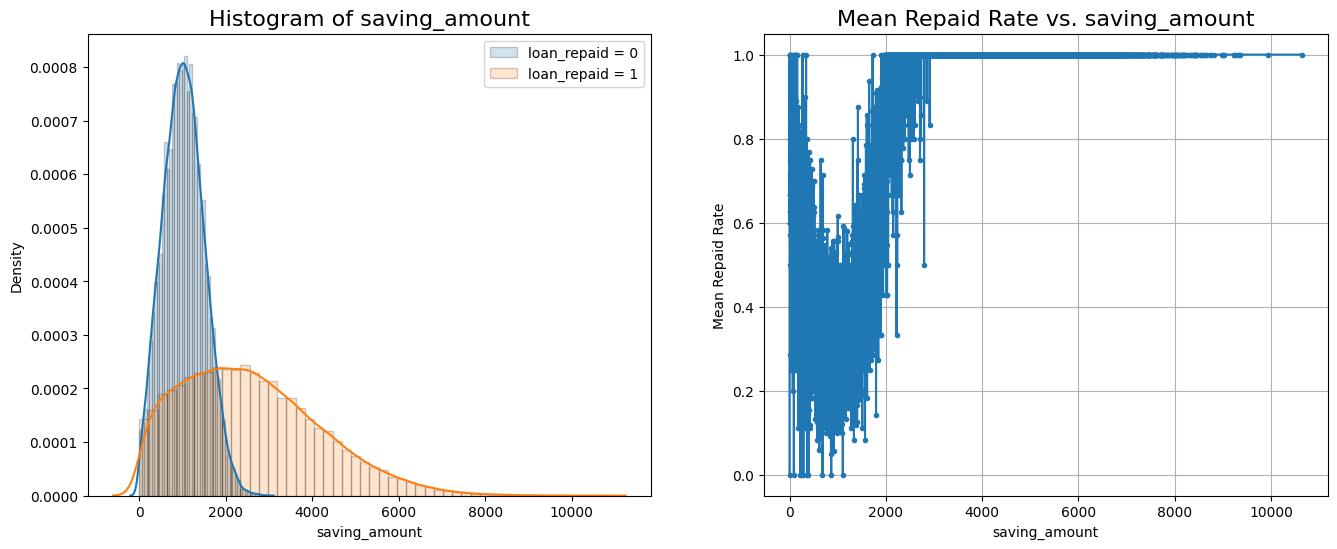

In [141]:
# Visualization of 'saving_amount'
grouped = data[['saving_amount', 'loan_repaid']].groupby('saving_amount')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['saving_amount'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['saving_amount'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of saving_amount', fontsize=16)
ax[0].legend()
ax[1].plot(mean['saving_amount'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. saving_amount', fontsize=16)
ax[1].set_xlabel('saving_amount')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

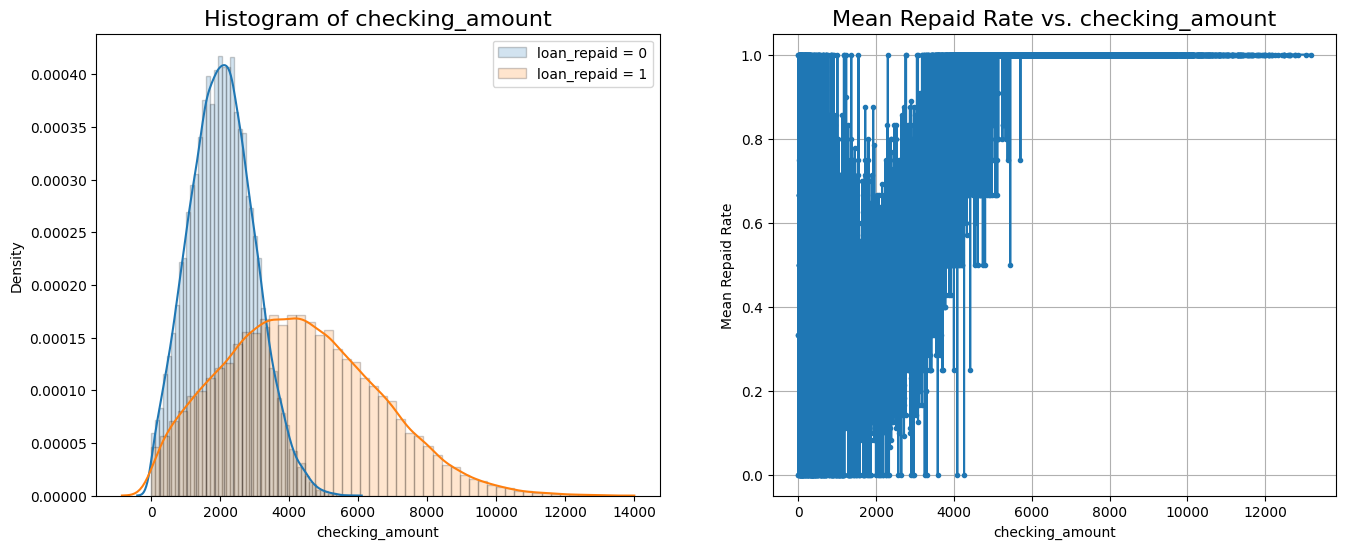

In [142]:
# Visualization of 'checking_amount'
grouped = data[['checking_amount', 'loan_repaid']].groupby('checking_amount')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['checking_amount'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['checking_amount'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of checking_amount', fontsize=16)
ax[0].legend()
ax[1].plot(mean['checking_amount'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. checking_amount', fontsize=16)
ax[1].set_xlabel('checking_amount')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

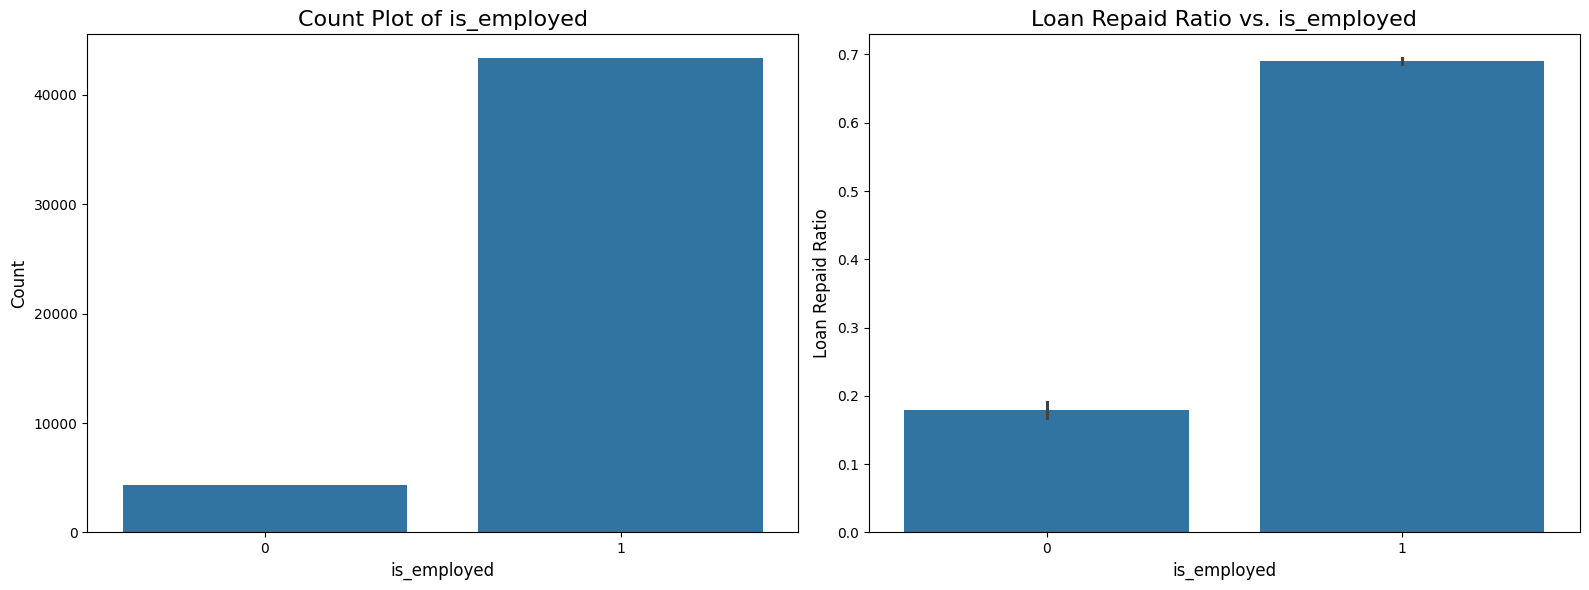

In [143]:
# visualization of 'is_employed'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='is_employed', data=data, ax=ax[0])
ax[0].set_xlabel('is_employed', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of is_employed', fontsize=16)

sns.barplot(x='is_employed', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('is_employed', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. is_employed', fontsize=16)
plt.tight_layout()
plt.show()

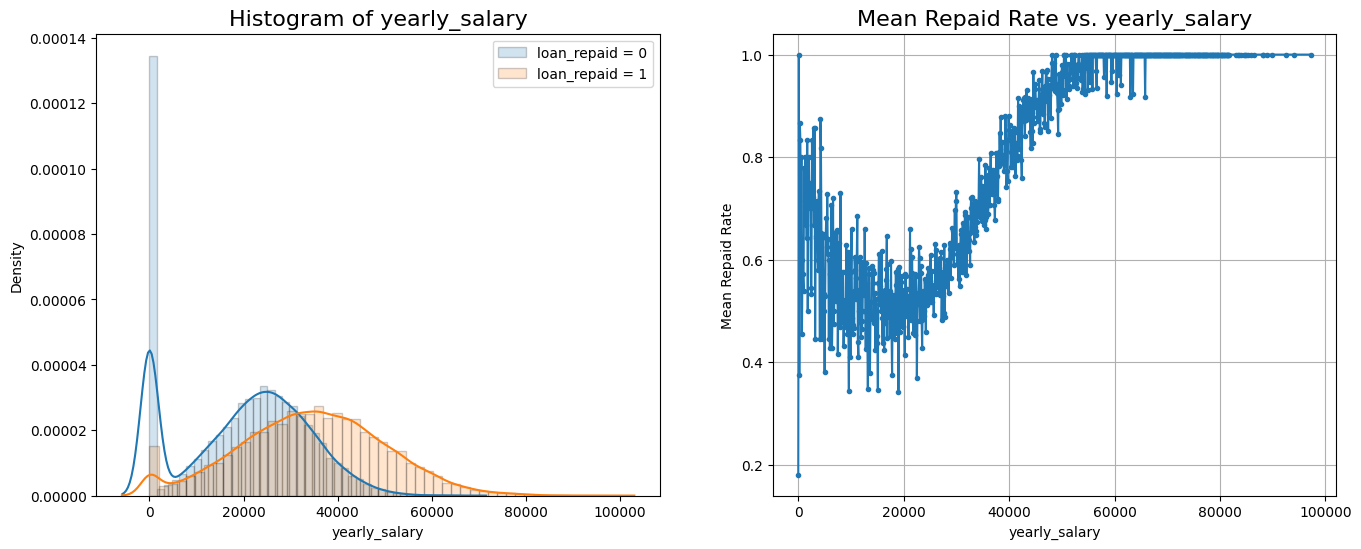

In [144]:
# Visualization of 'yearly_salary'
grouped = data[['yearly_salary', 'loan_repaid']].groupby('yearly_salary')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['yearly_salary'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['yearly_salary'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of yearly_salary', fontsize=16)
ax[0].legend()
ax[1].plot(mean['yearly_salary'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. yearly_salary', fontsize=16)
ax[1].set_xlabel('yearly_salary')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

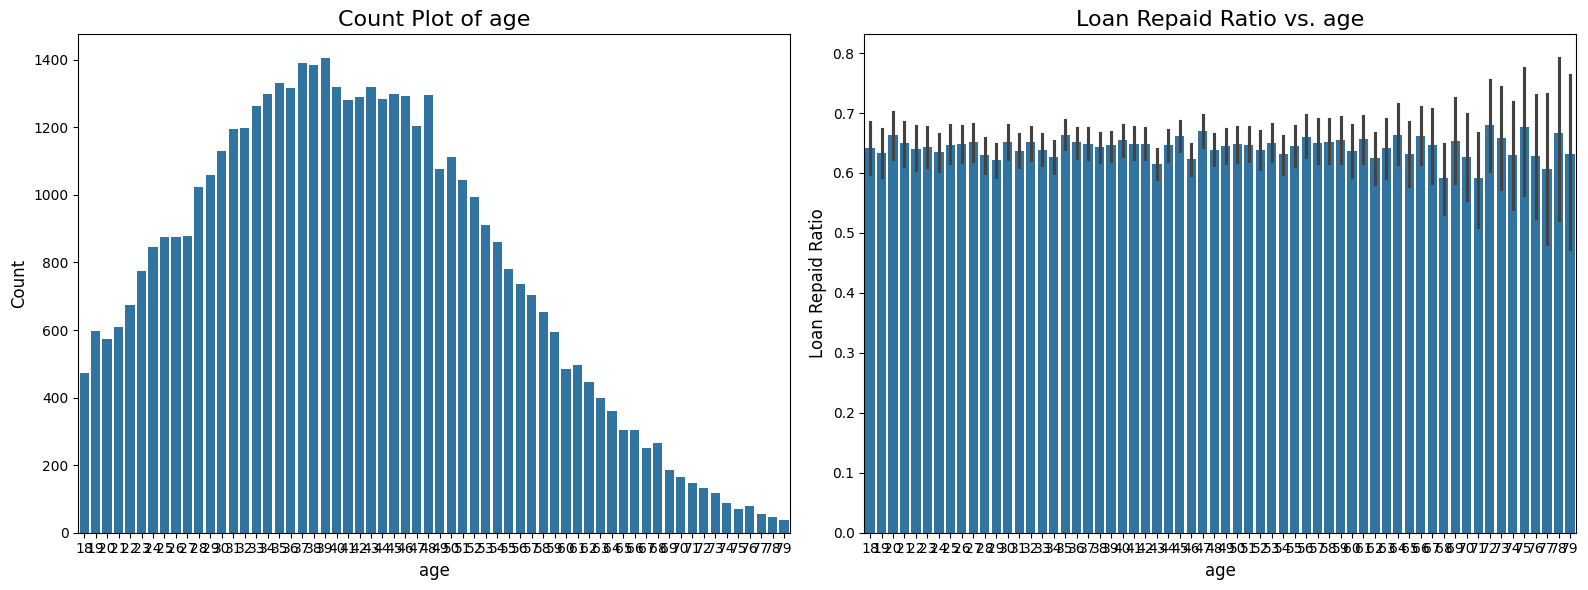

In [145]:
# visualization of 'age'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='age', data=data, ax=ax[0])
ax[0].set_xlabel('age', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of age', fontsize=16)

sns.barplot(x='age', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('age', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. age', fontsize=16)
plt.tight_layout()
plt.show()

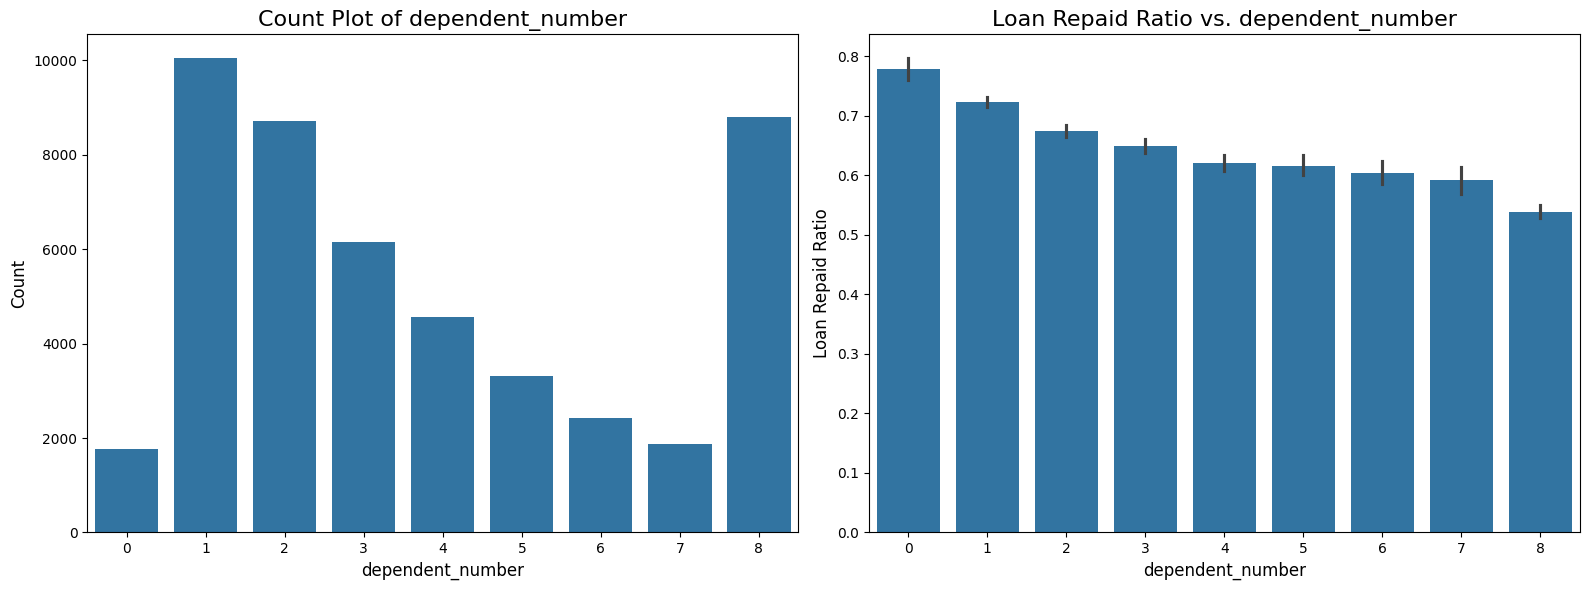

In [146]:
# visualization of 'age'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dependent_number', data=data, ax=ax[0])
ax[0].set_xlabel('dependent_number', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dependent_number', fontsize=16)

sns.barplot(x='dependent_number', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('dependent_number', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. dependent_number', fontsize=16)
plt.tight_layout()
plt.show()

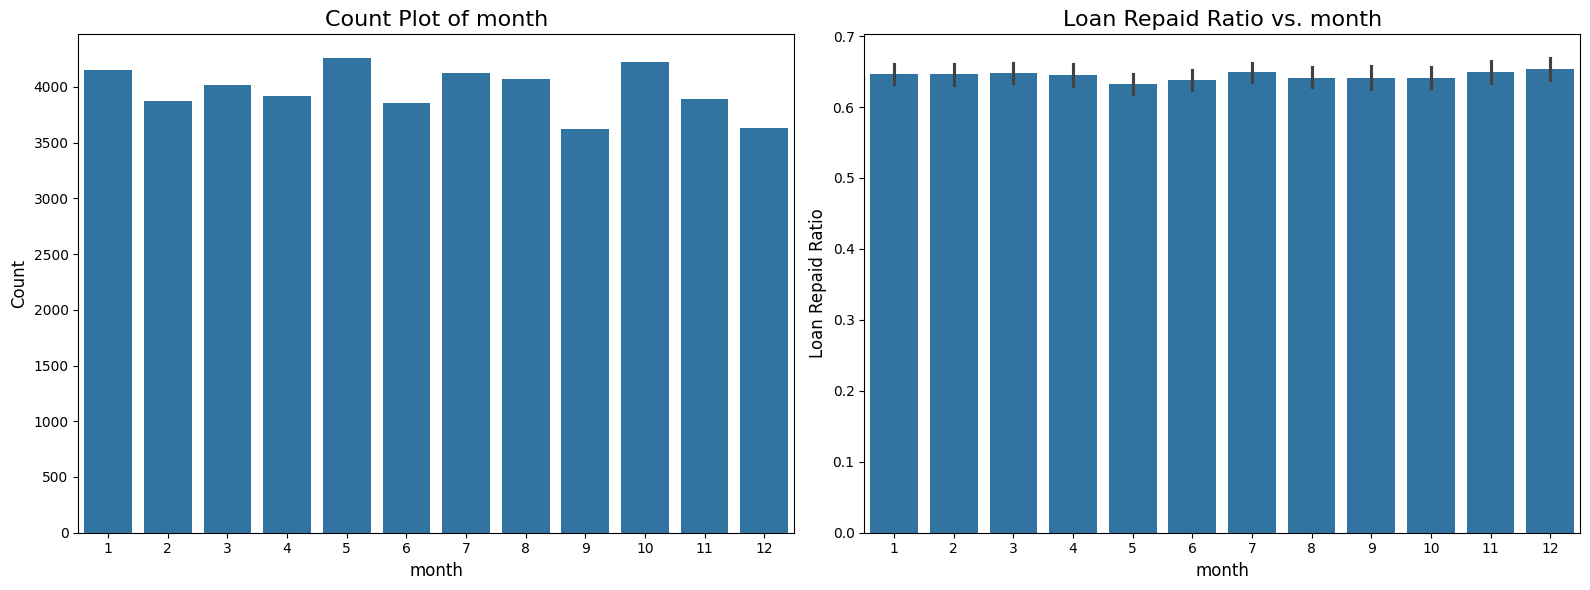

In [147]:
# visualization of 'month'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='month', data=data, ax=ax[0])
ax[0].set_xlabel('month', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of month', fontsize=16)

sns.barplot(x='month', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('month', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. month', fontsize=16)
plt.tight_layout()
plt.show()

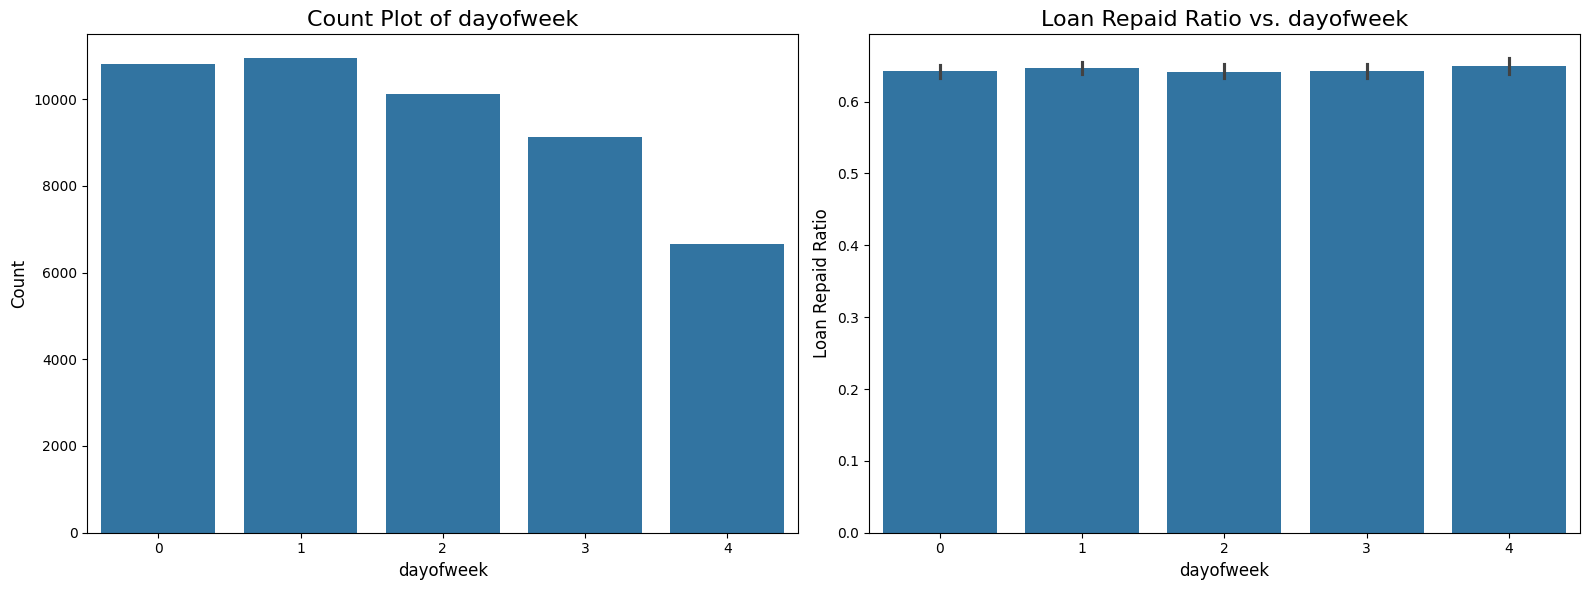

In [148]:
# visualization of 'dayofweek'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dayofweek', data=data, ax=ax[0])
ax[0].set_xlabel('dayofweek', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dayofweek', fontsize=16)

sns.barplot(x='dayofweek', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('dayofweek', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. dayofweek', fontsize=16)
plt.tight_layout()
plt.show()

# 特征工程

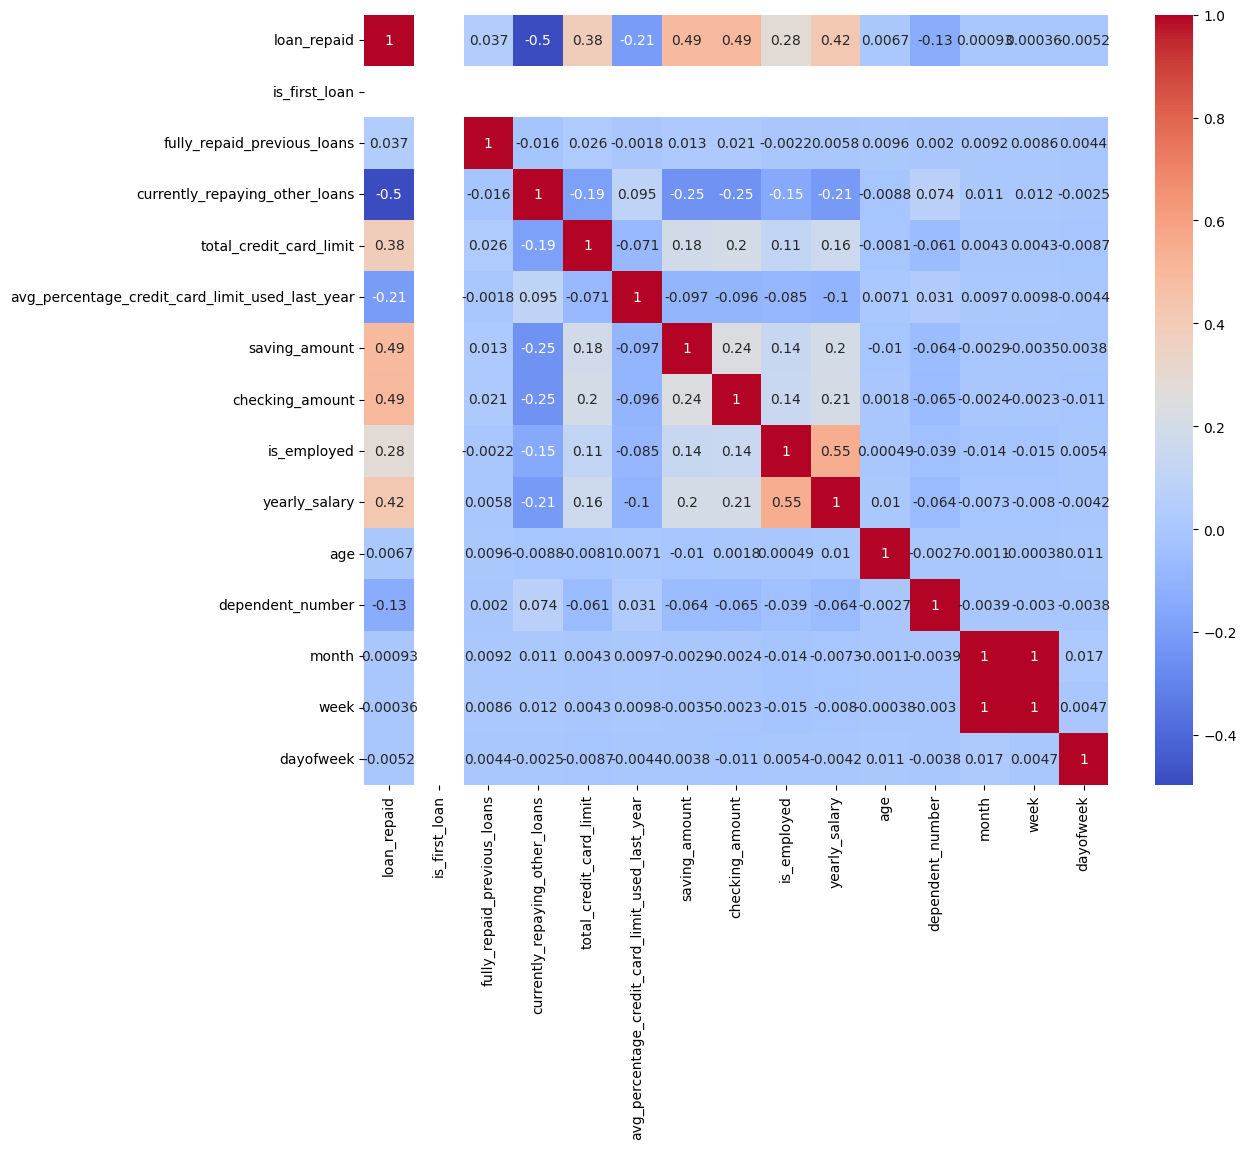

In [149]:
# 只选择数值列
numeric_data = data.select_dtypes(include=[np.number])

# 删除所有有缺失值的行
clean_data = numeric_data.dropna(axis=0, how='any')

# 绘制热力图
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(clean_data.corr(), ax=ax, annot=True, cmap='coolwarm')  # 可选添加 annot=True 以显示相关系数
plt.show()

In [150]:
# there is a clear connection between 'is_first_loan' 
# and 'fully_repaid_previous_loans', 'currently_repaying_other_loans'
print(data[data['is_first_loan'] == 1]['fully_repaid_previous_loans'].unique())
print(data[data['is_first_loan'] == 1]['currently_repaying_other_loans'].unique())

[nan]
[nan]


In [151]:
# fill missing values with -1 for 'fully_repaid_previous_loans' and 'currently_repaying_other_loans'
data = data.fillna({'fully_repaid_previous_loans': -1, 'currently_repaying_other_loans': -1})

In [152]:
# fill missing values with median
median = data['avg_percentage_credit_card_limit_used_last_year'].median()
data = data.fillna({'avg_percentage_credit_card_limit_used_last_year': median})

In [153]:
# drop useless features
data = data.drop(labels=['month', 'week', 'dayofweek'], axis=1, inplace=False)

In [154]:
# final data set for model building
data.head()

,loan_purpose,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
3,other,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,business,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4
6,business,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2
7,emergency_funds,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2
8,investment,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1


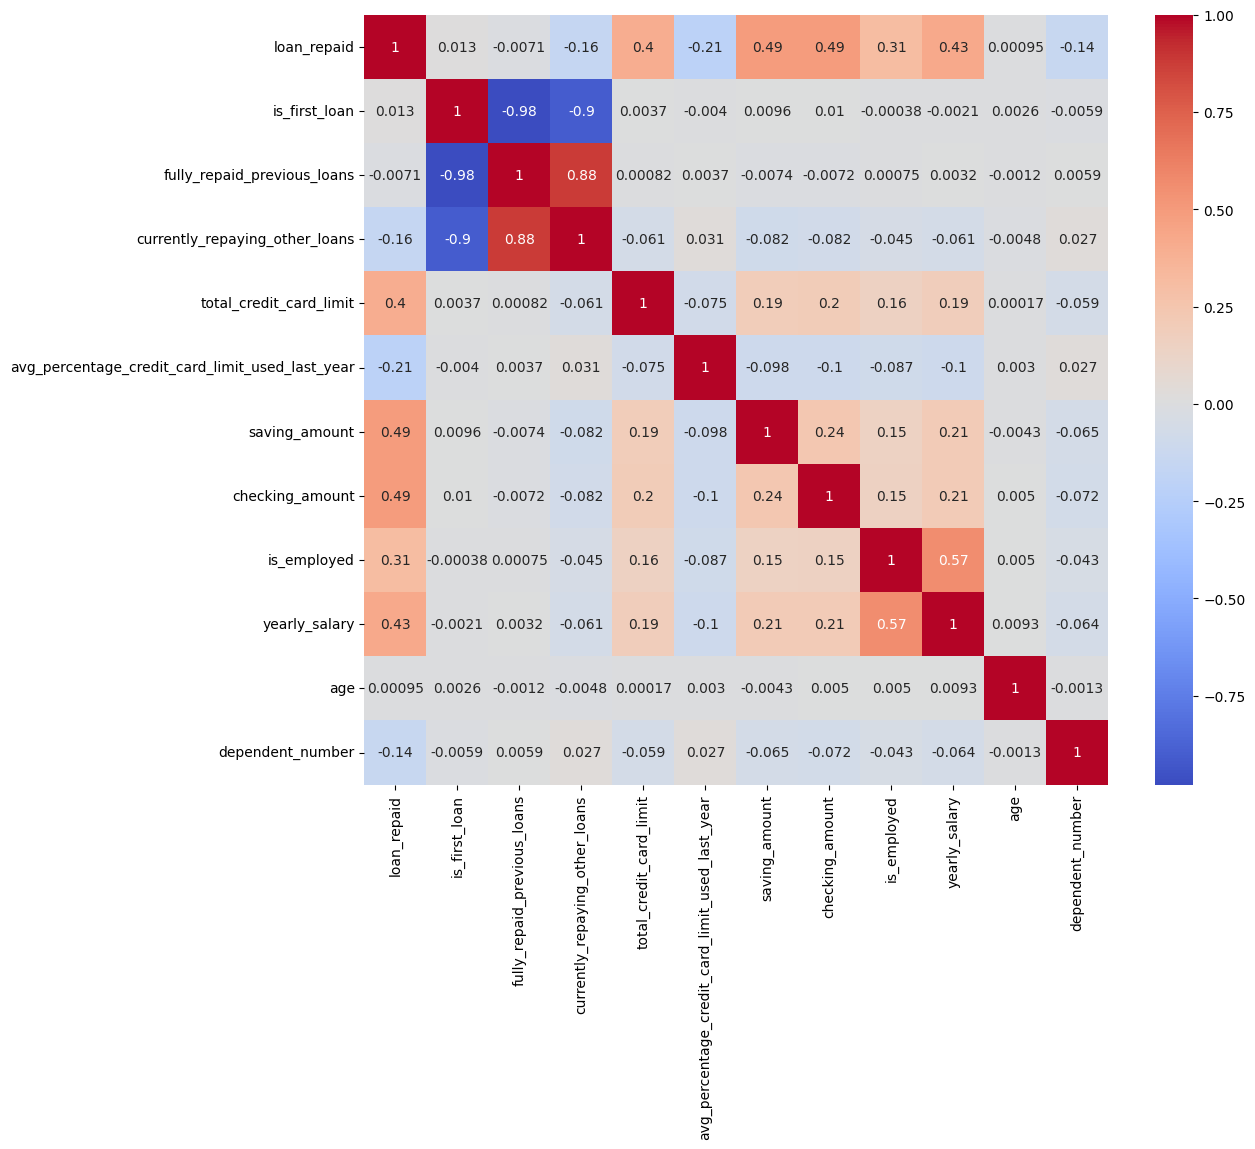

In [155]:
# 只选择数值列
numeric_data = data.select_dtypes(include=[np.number])

# 绘制热力图
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(numeric_data.corr(), ax=ax, annot=True, cmap='coolwarm')  # 使用 coolwarm 配色并显示相关系数
plt.show()

# 模型

In [156]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [157]:
data.head()

,loan_purpose,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
3,other,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,business,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4
6,business,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2
7,emergency_funds,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2
8,investment,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1


In [158]:
# encoding 'loan_purpose'
encoder = LabelEncoder()
data['loan_purpose'] = encoder.fit_transform(data['loan_purpose'])

In [163]:
# define categorical features
categorical_feature = ['loan_purpose', 'is_first_loan', 'fully_repaid_previous_loans', 
                       'currently_repaying_other_loans', 'is_employed']
target = 'loan_repaid'

data[categorical_feature] = data[categorical_feature].astype('category')
data[target] = data[target].astype('int')

In [164]:
# split into training and test data set
X = data.drop('loan_repaid', axis=1)
y = data['loan_repaid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [165]:
# create LightGBM dataset
d_train = lgb.Dataset(data=X_train, label=y_train, categorical_feature=categorical_feature, free_raw_data=False)